In [36]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [37]:
# Step 1: Data Cleaning & Preprocessing
# Loading the data
data = pd.read_excel('Online Retail.xlsx')


In [39]:
# Cleaning the data
data_clean = data.dropna(subset=['CustomerID'])
data_clean = data_clean[data_clean['Quantity'] > 0]  # Remove invalid transactions (Quantity <= 0)
data_clean = data_clean.reset_index(drop=True)


In [7]:
print(data_clean.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [40]:
# Date Conversion and Data Type Adjustments
data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'])
data_clean['CustomerID'] = data_clean['CustomerID'].astype(str)

In [10]:
print(data_clean.dtypes)


InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object


In [41]:
# Step 2: Feature Engineering
# Create a column for TotalAmount
data_clean['TotalAmount'] = data_clean['Quantity'] * data_clean['UnitPrice']

# Recency, Frequency, and Monetary
today_date = data_clean['InvoiceDate'].max() + pd.Timedelta(days=1)  # Setting today as max date + 1 day

# RFM features per customer
customer_data = data_clean.groupby('CustomerID').agg(
    recency=('InvoiceDate', lambda x: (today_date - x.max()).days),
    frequency=('InvoiceNo', 'nunique'),
    monetary=('TotalAmount', 'sum')
).reset_index()
# Check the first few rows
print(customer_data.head())

  CustomerID  recency  frequency  monetary
0    12346.0      326          1  77183.60
1    12347.0        2          7   4310.00
2    12348.0       75          4   1797.24
3    12349.0       19          1   1757.55
4    12350.0      310          1    334.40


In [43]:
# Step 3: Normalization (Standardization)
scaler = StandardScaler()
customer_data[['recency', 'frequency', 'monetary']] = scaler.fit_transform(customer_data[['recency', 'frequency', 'monetary']])

# Verify normalization
print(customer_data.head())


  CustomerID   recency  frequency  monetary
0    12346.0  2.334858  -0.424675  8.359634
1    12347.0 -0.905199   0.354080  0.251046
2    12348.0 -0.175186  -0.035297 -0.028546
3    12349.0 -0.735196  -0.424675 -0.032963
4    12350.0  2.174855  -0.424675 -0.191315


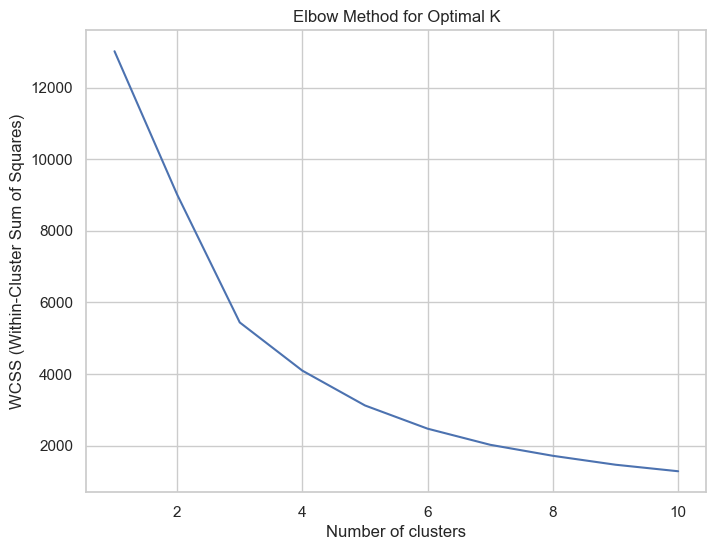

  CustomerID   recency  frequency  monetary  Segment
0    12346.0  2.334858  -0.424675  8.359634        0
1    12347.0 -0.905199   0.354080  0.251046        3
2    12348.0 -0.175186  -0.035297 -0.028546        3
3    12349.0 -0.735196  -0.424675 -0.032963        3
4    12350.0  2.174855  -0.424675 -0.191315        1


In [45]:
# Step 4: KMeans Clustering
# Elbow Method to determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(customer_data[['recency', 'frequency', 'monetary']])
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Apply KMeans with K=4 (based on elbow method)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
customer_data['Segment'] = kmeans.fit_predict(customer_data[['recency', 'frequency', 'monetary']])
# Check the clustered data
print(customer_data.head())


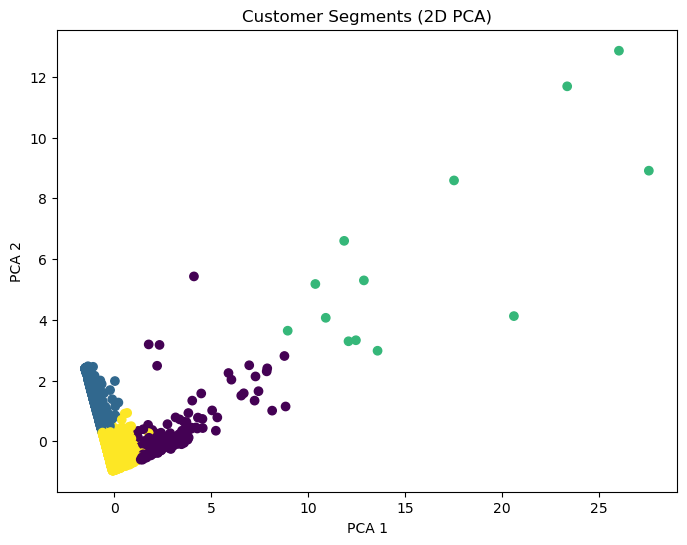

In [17]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_data[['recency', 'frequency', 'monetary']])

# Add PCA results to dataframe
customer_data['PCA1'] = pca_result[:, 0]
customer_data['PCA2'] = pca_result[:, 1]

# 2D scatter plot of PCA results
plt.figure(figsize=(8, 6))
plt.scatter(customer_data['PCA1'], customer_data['PCA2'], c=customer_data['Segment'], cmap='viridis')
plt.title('Customer Segments (2D PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

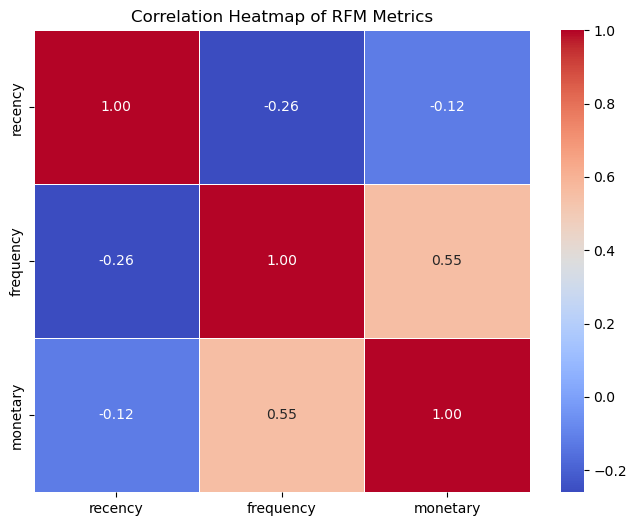

In [26]:
# Create a correlation matrix for RFM metrics
corr_matrix = customer_data[['recency', 'frequency', 'monetary']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of RFM Metrics')
plt.show()

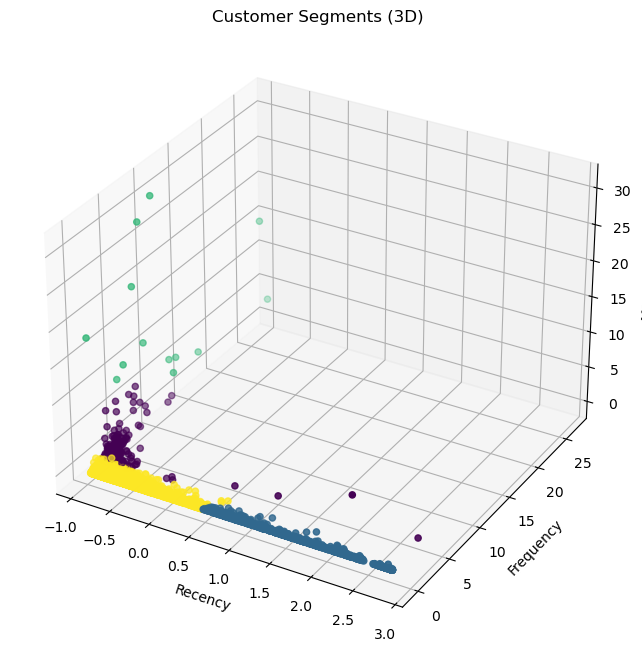

In [16]:
from mpl_toolkits.mplot3d import Axes3D

# 3D visualization of clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(customer_data['recency'], customer_data['frequency'], customer_data['monetary'], c=customer_data['Segment'], cmap='viridis')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('Customer Segments (3D)')
plt.show()

In [19]:
# Segment profiling - Calculate mean, median, and std for each RFM metric in each segment
segment_profiles = customer_data.groupby('Segment').agg(
    recency_mean=('recency', 'mean'),
    frequency_mean=('frequency', 'mean'),
    monetary_mean=('monetary', 'mean'),
    recency_median=('recency', 'median'),
    frequency_median=('frequency', 'median'),
    monetary_median=('monetary', 'median'),
    recency_std=('recency', 'std'),
    frequency_std=('frequency', 'std'),
    monetary_std=('monetary', 'std'),
    customer_count=('CustomerID', 'count')
).reset_index()

# Display the segment profiles
print(segment_profiles)

   Segment  recency_mean  frequency_mean  monetary_mean  recency_median  \
0        0     -0.768467        2.307119       1.157137       -0.875199   
1        1      1.560485       -0.353057      -0.175325        1.504844   
2        2     -0.851352       10.178375      13.940309       -0.905199   
3        3     -0.486086       -0.079979      -0.078344       -0.595194   

   frequency_median  monetary_median  recency_std  frequency_std  \
0          1.911590         0.645729     0.402890       1.504472   
1         -0.424675        -0.194039     0.661038       0.139101   
2          7.622461        12.832214     0.114860       8.231408   
3         -0.165090        -0.136638     0.361865       0.365747   

   monetary_std  customer_count  
0      1.448248             211  
1      0.070728            1062  
2      8.870763              13  
3      0.170502            3053  


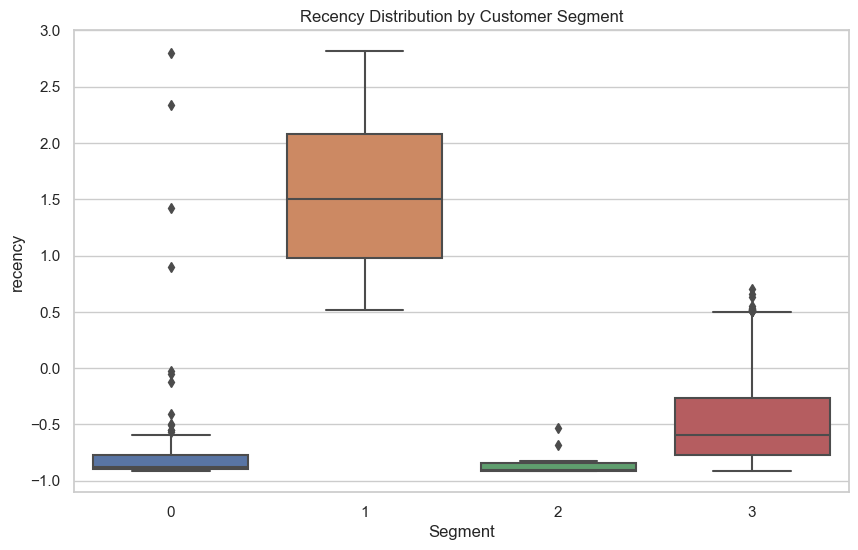

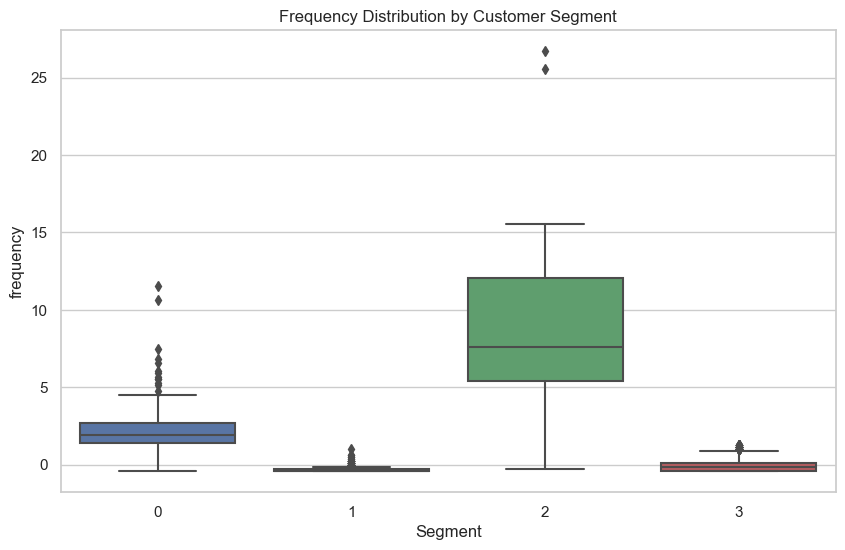

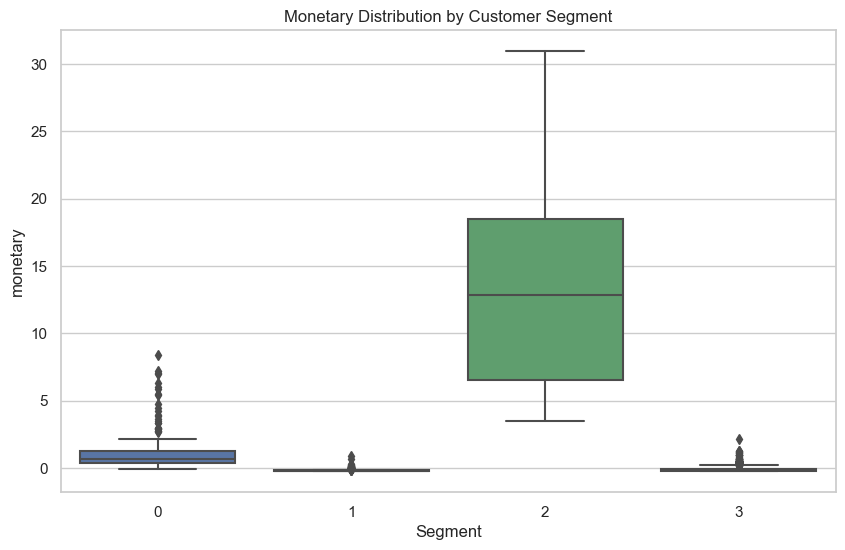

In [47]:
 #Step 9: Distribution Plots
# Ensure the 'figures' directory exists for saving plots
if not os.path.exists('figures'):
    os.makedirs('figures')

# Boxplot for Recency Distribution across segments
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='recency', data=customer_data)
plt.title('Recency Distribution by Customer Segment')
plt.savefig('figures/recency_distribution_boxplot.png')  # Save boxplot as PNG
plt.show()

# Boxplot for Frequency Distribution across segments
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='frequency', data=customer_data)
plt.title('Frequency Distribution by Customer Segment')
plt.savefig('figures/frequency_distribution_boxplot.png')  # Save boxplot as PNG
plt.show()

# Boxplot for Monetary Distribution across segments
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='monetary', data=customer_data)
plt.title('Monetary Distribution by Customer Segment')
plt.savefig('figures/monetary_distribution_boxplot.png')  # Save boxplot as PNG
plt.show()

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


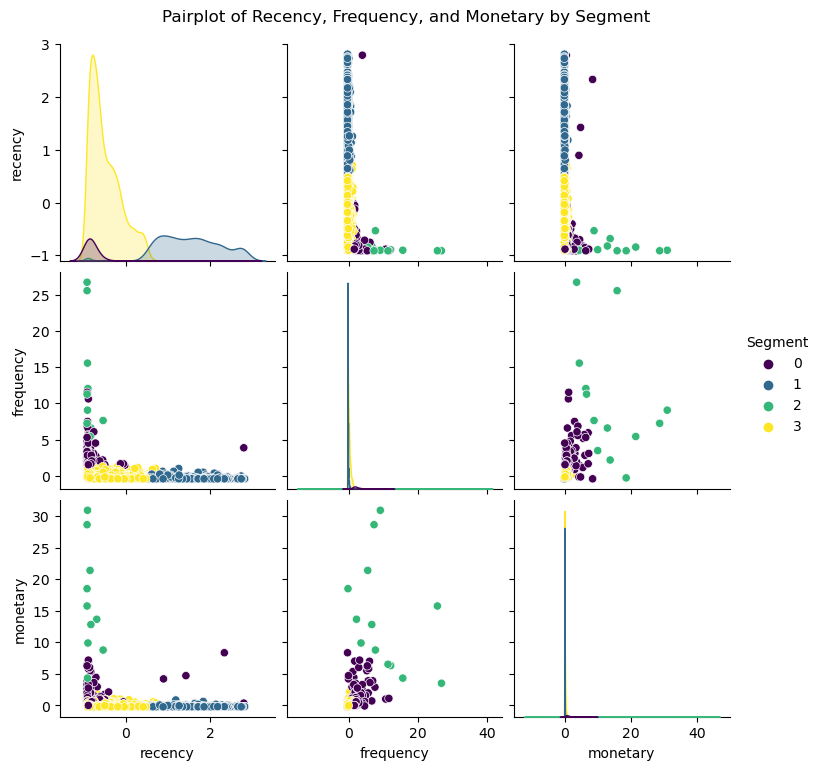

In [21]:
sns.pairplot(customer_data[['recency', 'frequency', 'monetary', 'Segment']], hue='Segment', palette='viridis')
plt.suptitle('Pairplot of Recency, Frequency, and Monetary by Segment', y=1.02)
plt.show()

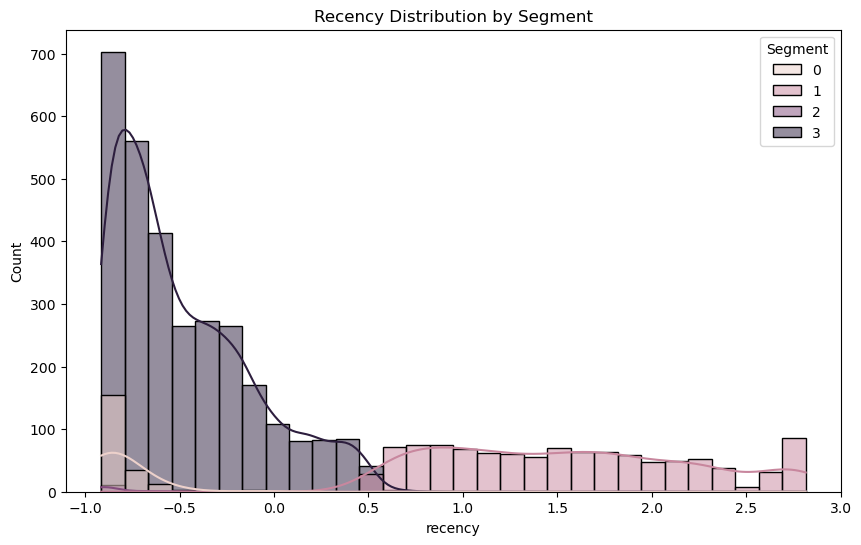

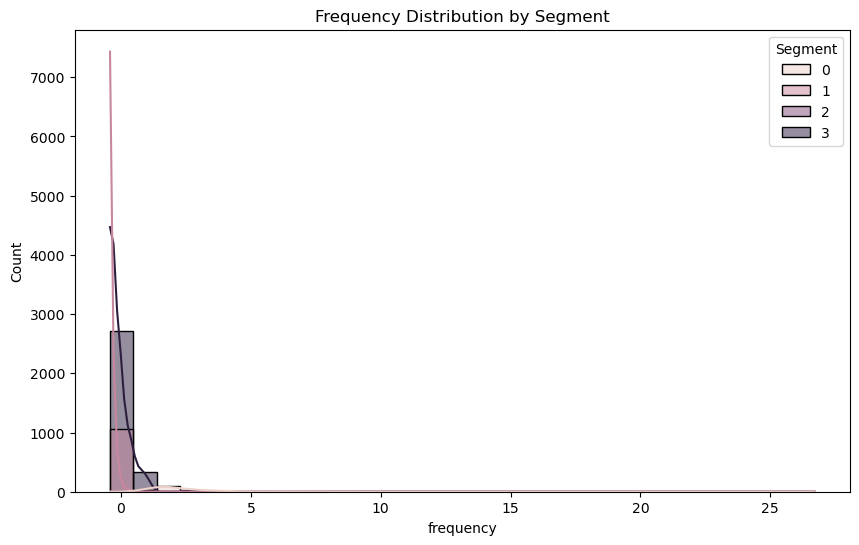

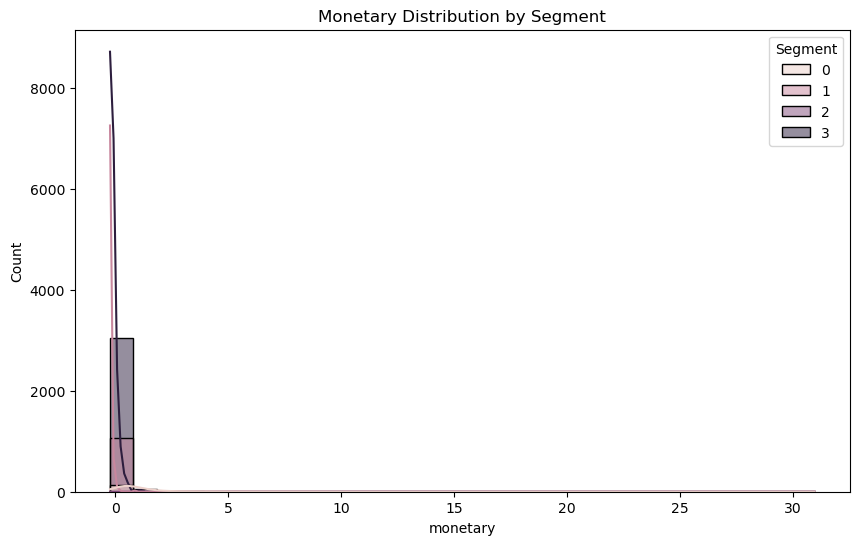

In [22]:
# Plot Histograms or KDE for Recency across segments
plt.figure(figsize=(10, 6))
sns.histplot(data=customer_data, x='recency', hue='Segment', kde=True, bins=30)
plt.title('Recency Distribution by Segment')
plt.show()

# Plot Histograms or KDE for Frequency across segments
plt.figure(figsize=(10, 6))
sns.histplot(data=customer_data, x='frequency', hue='Segment', kde=True, bins=30)
plt.title('Frequency Distribution by Segment')
plt.show()

# Plot Histograms or KDE for Monetary across segments
plt.figure(figsize=(10, 6))
sns.histplot(data=customer_data, x='monetary', hue='Segment', kde=True, bins=30)
plt.title('Monetary Distribution by Segment')
plt.show()

In [49]:

# Calculate the silhouette score
silhouette_avg = silhouette_score(customer_data[['recency', 'frequency', 'monetary']], customer_data['Segment'])
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.6161144819517275


In [50]:
# Step 11: Davies-Bouldin Index
db_index = davies_bouldin_score(customer_data[['recency', 'frequency', 'monetary']], customer_data['Segment'])
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 0.7524015567669395
